# Initialization

This competition seems requires strong scientific background and I had lot of confusion during EDA process. Therefore, I just build a simple starter for future coding.

## Load Library

In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import polars as pl
import numpy as np
import torch
# import torch.nn as nn
# import torch.optim as optim
# from torch.utils.data import DataLoader, Dataset
from tqdm import tqdm
import pickle
import time
import os
import pickle
import seaborn as sns
import scipy.stats
from sklearn.model_selection import cross_val_predict
from sklearn.linear_model import Ridge
from sklearn.metrics import r2_score, mean_squared_error

In [2]:
# Load Meta-Data
PATH = "/kaggle/input/ariel-data-challenge-2024"
train_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_adc_info.csv', 
                             index_col='planet_id')
train_labels = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/train_labels.csv',
                           index_col='planet_id')
wavelengths = pd.read_csv(f'{PATH}/wavelengths.csv')

# Pre-Processing
## Load Functions

In [3]:
%%writefile utils.py
import pandas as pd
import polars as pl
import numpy as np
from tqdm import tqdm
import pickle
PATH = "/kaggle/input/ariel-data-challenge-2024"
def load_signal_data(planet_id, dataset, instrument, img_size):
    file_path = f'{PATH}/{dataset}/{planet_id}/{instrument}_signal.parquet'
    signal = pl.read_parquet(file_path)
    mean_signal = signal.cast(pl.Int32).sum_horizontal().cast(pl.Float32).to_numpy() / img_size # mean over the 32*32 pixels
    net_signal = mean_signal[1::2] - mean_signal[0::2]
    return net_signal

def read_and_preprocess(dataset, planet_ids, instrument = "AIRS-CH0"):
    """Read the files for all planet_ids and extract the time series.
    Parameters
    dataset: 'train' or 'test'
    planet_ids: list of planet ids
    instrument: the instrument of observation, 'AIRS-CH0' or 'FGS1', default to 'AIRS-CH0'
    Returns
    dataframe with one row per planet_id and 67500 values per row for FGS1 and 5624 for AIRS-CH0
    """
    img_size = 1024 if instrument == "FGS1" else 32*356
    column_num = 67500 if instrument == 'FGS1' else 5625
    raw_train = np.full((len(planet_ids), column_num), np.nan, dtype=np.float32)
    for i, planet_id in tqdm(list(enumerate(planet_ids))):
        raw_train[i] = load_signal_data(planet_id, dataset, instrument, img_size)
    return raw_train

def feature_engineering(f_raw, a_raw, adc_info):
    """Create a dataframe with two features from the raw data.
    
    Parameters:
    f_raw: ndarray of shape (n_planets, 67500)
    a_raw: ndarray of shape (n_planets, 5625)
    adc_info: metadata dataframe, either train_adc_info or test_adc_info
    
    Return value:
    df: DataFrame of shape (n_planets, 4)
    """
    f_obscured = f_raw[:, 23500:44000].mean(axis=1)
    f_unobscured = (f_raw[:, :20500].mean(axis=1) + f_raw[:, 47000:].mean(axis=1)) / 2
    f_relative_reduction = (f_unobscured - f_obscured) / f_unobscured
    a_obscured = a_raw[:, 1958:3666].mean(axis=1)
    a_unobscured = (a_raw[:, :1708].mean(axis=1) + a_raw[:, 3916:].mean(axis=1)) / 2
    a_relative_reduction = (a_unobscured - a_obscured) / a_unobscured

    df = pd.DataFrame({'a_relative_reduction': a_relative_reduction,
                       'f_relative_reduction': f_relative_reduction,
                       'a_obscured': a_obscured, 
                       'f_obscured': f_obscured})
    
    df = pd.concat([df, adc_info.reset_index().iloc[:, 1:6]], axis=1)
    
    return df

Writing utils.py


In [4]:
%%writefile -a utils.py

def postprocessing(pred_array, index, sigma_pred):
    """Create a submission dataframe from its components
    
    Parameters:
    pred_array: ndarray of shape (n_samples, 283)
    index: pandas.Index of length n_samples with name 'planet_id'
    sigma_pred: float
    
    Return value:
    df: DataFrame of shape (n_samples, 566) with planet_id as index
    """
    return pd.concat([pd.DataFrame(pred_array.clip(0, None), index=index, columns=wavelengths.columns),
                      pd.DataFrame(sigma_pred, index=index, columns=[f"sigma_{i}" for i in range(1, 284)])],
                     axis=1)

class ParticipantVisibleError(Exception):
    pass

def competition_score(
        solution: pd.DataFrame,
        submission: pd.DataFrame,
        naive_mean: float,
        naive_sigma: float,
        sigma_true: float,
        row_id_column_name='planet_id',
    ) -> float:
    '''
    This is a Gaussian Log Likelihood based metric. For a submission, which contains the predicted mean (x_hat) and variance (x_hat_std),
    we calculate the Gaussian Log-likelihood (GLL) value to the provided ground truth (x). We treat each pair of x_hat,
    x_hat_std as a 1D gaussian, meaning there will be 283 1D gaussian distributions, hence 283 values for each test spectrum,
    the GLL value for one spectrum is the sum of all of them.

    Inputs:
        - solution: Ground Truth spectra (from test set)
            - shape: (nsamples, n_wavelengths)
        - submission: Predicted spectra and errors (from participants)
            - shape: (nsamples, n_wavelengths*2)
        naive_mean: (float) mean from the train set.
        naive_sigma: (float) standard deviation from the train set.
        sigma_true: (float) essentially sets the scale of the outputs.
    '''

    del solution[row_id_column_name]
    del submission[row_id_column_name]

    if submission.min().min() < 0:
        raise ParticipantVisibleError('Negative values in the submission')
    for col in submission.columns:
        if not pd.api.types.is_numeric_dtype(submission[col]):
            raise ParticipantVisibleError(f'Submission column {col} must be a number')

    n_wavelengths = len(solution.columns)
    if len(submission.columns) != n_wavelengths*2:
        raise ParticipantVisibleError('Wrong number of columns in the submission')

    y_pred = submission.iloc[:, :n_wavelengths].values
    # Set a non-zero minimum sigma pred to prevent division by zero errors.
    sigma_pred = np.clip(submission.iloc[:, n_wavelengths:].values, a_min=10**-15, a_max=None)
    y_true = solution.values

    GLL_pred = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_pred, scale=sigma_pred))
    GLL_true = np.sum(scipy.stats.norm.logpdf(y_true, loc=y_true, scale=sigma_true * np.ones_like(y_true)))
    GLL_mean = np.sum(scipy.stats.norm.logpdf(y_true, loc=naive_mean * np.ones_like(y_true), scale=naive_sigma * np.ones_like(y_true)))

    submit_score = (GLL_pred - GLL_mean)/(GLL_true - GLL_mean)
    return float(np.clip(submit_score, 0.0, 1.0))

Appending to utils.py


In [5]:
exec(open('utils.py', 'r').read())

## Load Data

In [6]:
%%time
if os.path.exists("/kaggle/input/adc24-intro-training/f_raw_train.pickle"):
    f_raw_train = np.load('/kaggle/input/adc24-intro-training/f_raw_train.pickle', allow_pickle=True)
else:
    f_raw_train = read_and_preprocess('train', train_labels.index, 'FGS1')
    with open('f_raw_train.pickle', 'wb') as f:
        pickle.dump(f_raw_train, f)

CPU times: user 10.3 ms, sys: 133 ms, total: 144 ms
Wall time: 1.42 s


In [7]:
%%time
if os.path.exists("/kaggle/input/adc24-intro-training/a_raw_train.pickle"):
    a_raw_train = np.load('/kaggle/input/adc24-intro-training/a_raw_train.pickle', allow_pickle=True)
else:
    a_raw_train = read_and_preprocess('train', train_labels.index)
    with open('a_raw_train.pickle', 'wb') as f:
        pickle.dump(a_raw_train, f)

CPU times: user 0 ns, sys: 13.4 ms, total: 13.4 ms
Wall time: 112 ms


## Feature Engineering

In [8]:
%%time
train = feature_engineering(f_raw_train, a_raw_train, train_adc_info)

CPU times: user 22 ms, sys: 0 ns, total: 22 ms
Wall time: 22.4 ms


## Data Plot

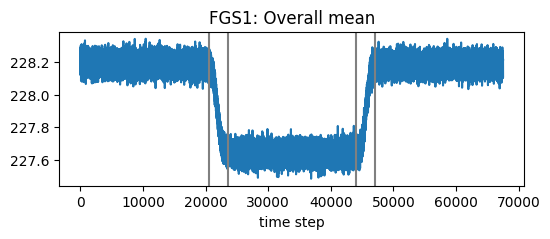

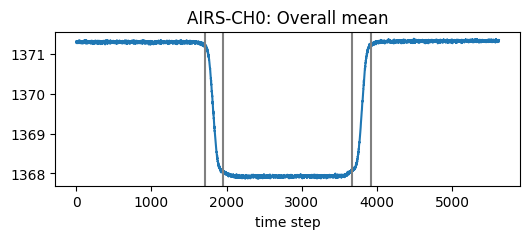

In [9]:
plt.figure(figsize=(6, 2))
plt.plot(f_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step, color='gray')
plt.xlabel('time step')
plt.title('FGS1: Overall mean')
plt.show()

plt.figure(figsize=(6, 2))
plt.plot(a_raw_train.mean(axis=0))
for time_step in [20500, 23500, 44000, 47000]:
    plt.axvline(time_step * 11250 // 135000, color='gray')
plt.xlabel('time step')
plt.title('AIRS-CH0: Overall mean')
plt.show()

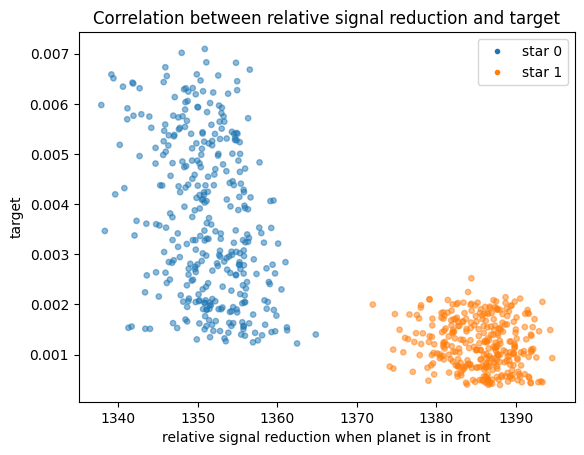

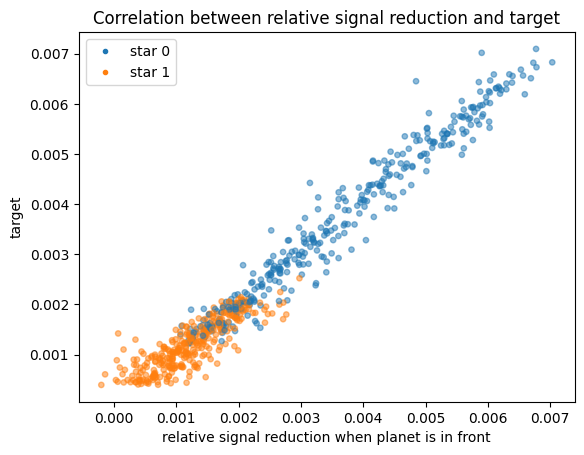

In [10]:
color_array = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(train.a_obscured, train_labels.wl_1, s=15, alpha=0.5,
            c=color_array[train.star])
plt.xlabel('relative signal reduction when planet is in front')
plt.ylabel('target')
plt.title('Correlation between relative signal reduction and target')
# plt.gca().set_aspect('equal')
points = [plt.Line2D([0], [0], label=f'star {i}', marker='o', markersize=3,
         markeredgecolor=color_array[i], markerfacecolor=color_array[i], linestyle='') for i in range(2)]

plt.legend(handles=points)
plt.show()

color_array = np.array(plt.rcParams['axes.prop_cycle'].by_key()['color'])
plt.scatter(train.a_relative_reduction, train_labels.wl_1, s=15, alpha=0.5,
            c=color_array[train.star])
plt.xlabel('relative signal reduction when planet is in front')
plt.ylabel('target')
plt.title('Correlation between relative signal reduction and target')
# plt.gca().set_aspect('equal')
points = [plt.Line2D([0], [0], label=f'star {i}', marker='o', markersize=3,
         markeredgecolor=color_array[i], markerfacecolor=color_array[i], linestyle='') for i in range(2)]

plt.legend(handles=points)
plt.show()

# Model
## Rigde Model

In [11]:
model = Ridge(alpha=1e-12)
selected_columns = ['a_relative_reduction','f_relative_reduction']
oof_pred = cross_val_predict(model, train[selected_columns], train_labels)

print(f"# R2 score: {r2_score(train_labels, oof_pred):.3f}")
sigma_pred = mean_squared_error(train_labels, oof_pred, squared=False)
print(f"# Root mean squared error: {sigma_pred:.6f}")

# R2 score: 0.971
# Root mean squared error: 0.000293


In [12]:
oof_df = postprocessing(oof_pred, train_adc_info.index, sigma_pred)
display(oof_df)

gll_score = competition_score(train_labels.copy().reset_index(),
                              oof_df.copy().reset_index(),
                              naive_mean=train_labels.values.mean(),
                              naive_sigma=train_labels.values.std(),
                              sigma_true=0.000003)
print(f"# Estimated competition score: {gll_score:.3f}")

,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
785834,0.001814,0.001849,0.001843,0.001839,0.001840,0.001832,0.001832,0.001844,0.001841,0.001837,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
14485303,0.001926,0.001958,0.001952,0.001948,0.001950,0.001942,0.001942,0.001951,0.001948,0.001945,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
17002355,0.003049,0.003076,0.003070,0.003065,0.003067,0.003059,0.003058,0.003067,0.003064,0.003059,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
24135240,0.001323,0.001356,0.001351,0.001347,0.001349,0.001342,0.001342,0.001351,0.001349,0.001345,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
25070640,0.002137,0.002168,0.002162,0.002158,0.002160,0.002152,0.002151,0.002161,0.002158,0.002154,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4249337798,0.000983,0.001008,0.001006,0.001002,0.001007,0.001002,0.001000,0.001004,0.001001,0.001000,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
4257395405,0.003848,0.003875,0.003868,0.003864,0.003865,0.003856,0.003856,0.003866,0.003863,0.003858,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
4266129805,0.006656,0.006684,0.006674,0.006669,0.006666,0.006654,0.006655,0.006670,0.006667,0.006660,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293


# Estimated competition score: 0.259


In [13]:
model.fit(train[selected_columns], train_labels)
with open('model.pickle', 'wb') as f:
    pickle.dump(model, f)
with open('sigma_pred.pickle', 'wb') as f:
    pickle.dump(sigma_pred, f)

## Inference

In [14]:
# Load the data
test_adc_info = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/test_adc_info.csv',
                           index_col='planet_id')
sample_submission = pd.read_csv('/kaggle/input/ariel-data-challenge-2024/sample_submission.csv',
                                index_col='planet_id')
f_raw_test = read_and_preprocess('test', sample_submission.index, 'FGS1')
a_raw_test = read_and_preprocess('test', sample_submission.index)
test = feature_engineering(f_raw_test, a_raw_test, test_adc_info)

# Load the model
with open('model.pickle', 'rb') as f:
    model = pickle.load(f)
with open('sigma_pred.pickle', 'rb') as f:
    sigma_pred = pickle.load(f)

# Predict
test_pred = model.predict(test[selected_columns])

# Package into submission file
sub_df = postprocessing(test_pred, sample_submission.index, sigma_pred)
display(sub_df)
sub_df.to_csv('submission.csv')

100%|██████████| 1/1 [00:01<00:00,  1.36s/it]


,wl_1,wl_2,wl_3,wl_4,wl_5,wl_6,wl_7,wl_8,wl_9,wl_10,...,sigma_274,sigma_275,sigma_276,sigma_277,sigma_278,sigma_279,sigma_280,sigma_281,sigma_282,sigma_283
planet_id,,,,,,,,,,,,,,,,,,,,,
499191466,0.002819,0.002847,0.002841,0.002836,0.002839,0.002831,0.00283,0.002838,0.002835,0.002831,...,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293,0.000293
